In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maiabdelhameed","key":"c4a347c86c0e74bccd8ea77f5a8b8edb"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:16<00:00, 151MB/s]
100% 2.29G/2.29G [00:16<00:00, 151MB/s]


In [5]:
!ls

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

## ***importing all needed modules***

In [26]:
import pandas as pd
import numpy as np
import cv2 as cv
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import tensorflow as tf

from sklearn.utils import class_weight

from keras.preprocessing.image import ImageDataGenerator

from keras.layers.normalization.batch_normalization import BatchNormalization

from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.models import Sequential

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras.applications.vgg16 import VGG16

from keras.models import Model
from pathlib import Path

In [8]:
xray_pne = '/content/files/chest_xray/train/PNEUMONIA/person1003_bacteria_2934.jpeg'

xray_norm = '/content/files/chest_xray/train/NORMAL/IM-0119-0001.jpeg'

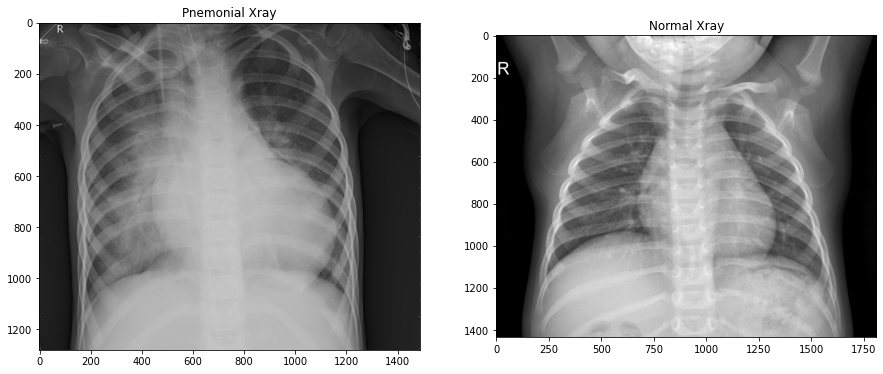

In [9]:
# Image shown before augmentation
plt.figure(figsize = (15,15))

plt.subplot(1,2,1)
xray_pne = np.asarray(cv.imread(xray_pne))
plt.title('Pnemonial Xray')
plt.imshow(xray_pne)

plt.subplot(1,2,2)
xray_norm = np.asarray(cv.imread(xray_norm))
plt.title('Normal Xray')
plt.imshow(xray_norm)

In [10]:
xray_norm.shape

(1434, 1810, 3)

In [11]:
xray_pne.shape

(1280, 1488, 3)

### ***Making sure all images have the same extension***

In [12]:
import os
import cv2
bad_list=[]
dir='/content/files/chest_xray'
subdir_list=os.listdir(dir) # create a list of the sub directories in the directory ie train or test
for d in subdir_list:  # iterate through the sub directories train and test
    dpath=os.path.join (dir, d) # create path to sub directory
    if d in ['test', 'train']:
        class_list=os.listdir(dpath) # list of classes ie dog or cat
       # print (class_list)
        for klass in class_list: # iterate through the two classes
            class_path=os.path.join(dpath, klass) # path to class directory
            #print(class_path)
            file_list=os.listdir(class_path) # create list of files in class directory
            for f in file_list: # iterate through the files
                fpath=os.path.join (class_path,f)
                index=f.rfind('.') # find index of period infilename
                ext=f[index+1:] # get the files extension
                if ext  not in ['jpeg']:
                    print(f'file {fpath}  has an invalid extension {ext}')
                    bad_list.append(fpath)                    
                else:
                    try:
                        img=cv2.imread(fpath)
                        size=img.shape
                    except:
                        print(f'file {fpath} is not a valid image file ')
                        bad_list.append(fpath)
                       
print (bad_list)


[]


# ***Now we will start Image Augmentation***

Augmenting the training dataset by zooming-in 50%

In [13]:
gen = ImageDataGenerator(rescale=1./255)

In [31]:
train_gen = ImageDataGenerator(zoom_range=[0.5,1.0],rescale=1./255).flow_from_directory(
    directory='/content/files/chest_xray/chest_xray/train',
    target_size=(320,320),
    color_mode='grayscale',
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=42
)


valid_gen = gen.flow_from_directory(
    directory='/content/files/chest_xray/chest_xray/val',
    target_size=(320,320),
    color_mode='grayscale',
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_gen = gen.flow_from_directory(
    directory='/content/files/chest_xray/chest_xray/test',
    target_size=(320,320),
    color_mode='grayscale',
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=42
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# **Image Preprocessing**

In [15]:
x_train, y_train= train_gen.next()
print(x_train.shape, y_train.shape)

(16, 320, 320, 1) (16, 2)


In [39]:
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=2,activation='relu',input_shape=(320,320,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(filters=16, kernel_size=2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=8, kernel_size=2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 319, 319, 32)      160       
                                                                 
 batch_normalization_8 (Batc  (None, 319, 319, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 159, 159, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 158, 158, 16)      2064      
                                                                 
 batch_normalization_9 (Batc  (None, 158, 158, 16)     64        
 hNormalization)                                                 
                                                      

In [40]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [41]:
early = EarlyStopping(monitor='val_loss', patience=5,mode='min', restore_best_weights=True,verbose=1)

reducelr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

checkpointer = ModelCheckpoint(filepath='xraychest.hdf5', verbose=1, save_best_only=True)


In [42]:
# class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y=y_train)

# ***Training the model and fine-tuning it***

In [43]:
history = model.fit(train_gen, epochs=10, validation_data=valid_gen, verbose=1, callbacks=[checkpointer, reducelr, early])

Epoch 1/10
326/326 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.8629
Epoch 1: val_loss improved from inf to 38.19888, saving model to xraychest.hdf5
326/326 [==============================] - 80s 241ms/step - loss: 0.5720 - accuracy: 0.8629 - val_loss: 38.1989 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
326/326 [==============================] - ETA: 0s - loss: 0.2528 - accuracy: 0.8993
Epoch 2: val_loss improved from 38.19888 to 0.74240, saving model to xraychest.hdf5
326/326 [==============================] - 78s 239ms/step - loss: 0.2528 - accuracy: 0.8993 - val_loss: 0.7424 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
326/326 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.9116
Epoch 3: val_loss did not improve from 0.74240
326/326 [==============================] - 77s 236ms/step - loss: 0.2220 - accuracy: 0.9116 - val_loss: 1.8109 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
326/326 [==============================] - ETA: 

Trial 1:
epochs=10, 2 layers

code: 
model.add(Conv2D(filters=8,kernel_size=2,activation='relu',input_shape=(320,320,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=16, kernel_size=2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.3))

# Results

loss: 0.1839 - accuracy: 0.9287 - val_loss: 2.2371 - val_accuracy: 0.6250 - lr: 5.0000e-04 
(check picture 1)

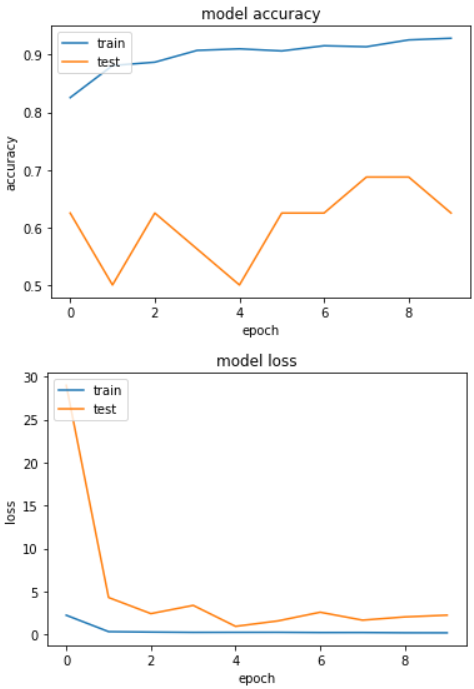

Trial 2:
epochs=10, 3 layers



In [ ]:
# ev = model.evaluate(test_generator, val_accuracy)
# print('Testing accuracy: ', ev[0])

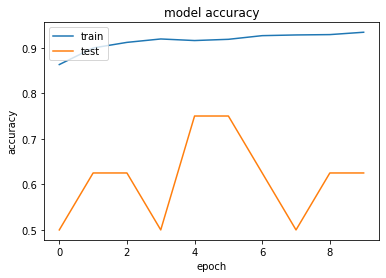

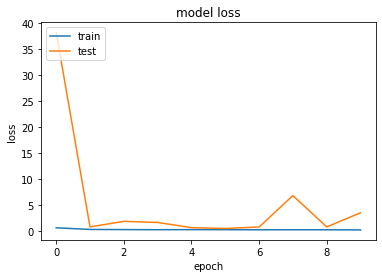

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ***Now we will start the transfer learning part***

In [46]:
model_transfer = VGG16(include_top=False, weights=None, input_shape=(320,320,1))
model_transfer.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 320, 320, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 320, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 160, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 160, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 160, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 80, 80, 128)       0     

In [47]:
for layer in model_transfer.layers:
  layer.trainable=False

In [48]:
out = Flatten()(model_transfer.output)
out = Dropout(0.3)(out)
prediction = Dense(2 ,activation='softmax')(out)

In [49]:
model_transfer = Model(inputs=model_transfer.input, outputs=prediction)
model_transfer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 320, 320, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 320, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 160, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 160, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 160, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 80, 80, 128)       0     

In [50]:
model_transfer.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [51]:
history = model_transfer.fit(train_gen, epochs=50, verbose=1)

Epoch 1/50
326/326 [==============================] - 90s 267ms/step - loss: 0.5715 - accuracy: 0.7427
Epoch 2/50
326/326 [==============================] - 86s 264ms/step - loss: 0.5411 - accuracy: 0.7429
Epoch 3/50
326/326 [==============================] - 86s 262ms/step - loss: 0.5178 - accuracy: 0.7441
Epoch 4/50
326/326 [==============================] - 85s 260ms/step - loss: 0.4958 - accuracy: 0.7496
Epoch 5/50
326/326 [==============================] - 85s 261ms/step - loss: 0.4787 - accuracy: 0.7594
Epoch 6/50
326/326 [==============================] - 86s 264ms/step - loss: 0.4627 - accuracy: 0.7734
Epoch 7/50
326/326 [==============================] - 85s 261ms/step - loss: 0.4534 - accuracy: 0.7812
Epoch 8/50
326/326 [==============================] - 86s 263ms/step - loss: 0.4401 - accuracy: 0.7956
Epoch 9/50
326/326 [==============================] - 85s 261ms/step - loss: 0.4271 - accuracy: 0.8064
Epoch 10/50
326/326 [==============================] - 85s 261ms/step - l

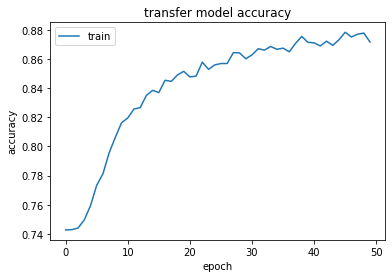

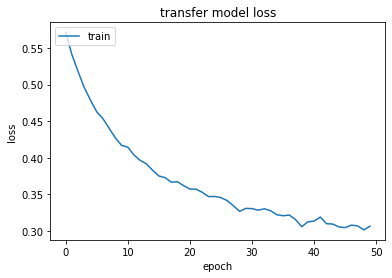

In [53]:
plt.plot(history.history['accuracy'])
plt.title('transfer model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('transfer model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ***Fine-Tuning Vs Transfer Learning***

## ***Results:***

Building a model and training/fine-tuning it shows greater results than using a transfer learning model.



